# Importar dependencias

In [10]:
import json
import torch
import os.path as osp
from torch_geometric.data import InMemoryDataset, download_url
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from torch_geometric.nn import MLP
from torch.nn import Module
from torch_geometric.nn import GCN, MLP
from torch.nn import Module
from torch_geometric.nn import GIN, MLP
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torchsummary import summary
import pandas as pd

# Cargar el dataset

In [11]:
torch.cuda.is_available()

True

In [12]:
class TournamentDataset(InMemoryDataset):

    TORUNAMENT_URL = 'https://drive.upm.es/s/mnsESjBucKUKsEg/download'

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['tournament.pt']

    @property
    def processed_file_names(self):
        return ['tournament.pt']

    @property
    def num_classes(self):
        return 3

    @property
    def num_features(self):
        return 500

    def download(self):
        download_url(self.TORUNAMENT_URL, self.raw_dir, filename='tournament.pt')

    def process(self):
        data_list = [torch.load(osp.join(self.raw_dir, 'tournament.pt'))]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

    def create_test_json(self, model, file_path, device="cpu"):
        data = self[0]

        model = model.to(device)
        data = data.to(device)

        model.eval()
        out = model(data.x, data.edge_index)
        y_pred = out[data.test_mask].argmax(dim=1)
        nid = data.nid[data.test_mask]

        pred = {
            'nid': nid.detach().cpu().numpy().tolist(),
            'y': y_pred.detach().cpu().numpy().tolist()
        }

        with open(file_path, 'w') as f:
            json.dump(pred, f)


In [13]:
dataset = TournamentDataset("tournament")
data = dataset[0]

In [14]:
print(data.train_mask.sum())
print(data.val_mask.sum())
print(data.test_mask.sum())


tensor(15970)
tensor(1775)
tensor(1972)


# Modelos

In [17]:
f1_by_model = {}

def train_model(model, model_name, dataset):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    optm_func = CrossEntropyLoss()

    data = dataset.to(device)

    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = optm_func(out[data.train_mask], data.y[data.train_mask].argmax(dim=1))
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss {loss.item()}")

    model.eval()
    out = model(data.x, data.edge_index)

    print("\n\nMODEL VALIDATION:\n")
    y_pred = out.argmax(dim=1)[data.val_mask].detach().cpu()
    y = data.y.argmax(dim=1)[data.val_mask].detach().cpu()

    f1_val = f1_score(y, y_pred, average='micro')
    print(f"Validation F1 score: {f1_val}")
    # sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues');

    print("\n\nMODEL TEST:\n")
    y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
    y_pred = y_pred.numpy()
    y = pd.read_csv('test_labels.csv')['y'].values
    y = torch.tensor(y).cpu().numpy()
    f1_test = f1_score(y, y_pred, average='micro')
    print(f"Test F1 score: {f1_test}")

    f1_by_model[model_name] = [f1_val, f1_test]

## Baseline - MLP

In [18]:
model = MLP(
    in_channels=dataset.num_node_features,
    out_channels=dataset.num_classes,
    num_layers=2,
    hidden_channels=32
)
summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 32]                  16,032
├─ModuleList: 1                          []                        --
|    └─BatchNorm: 2-2                    [-1, 32]                  --
|    |    └─BatchNorm1d: 3-1             [-1, 32]                  64
├─ReLU: 1-1                              [-1, 32]                  --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-3                       [-1, 3]                   99
Total params: 16,195
Trainable params: 16,195
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 38.28
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 38.35


In [19]:
train_model(model, "MLP", data)

Epoch 0: Loss 1.1843825578689575
Epoch 10: Loss 0.4116630256175995
Epoch 20: Loss 0.2973274290561676
Epoch 30: Loss 0.24203188717365265
Epoch 40: Loss 0.20586766302585602
Epoch 50: Loss 0.17445529997348785
Epoch 60: Loss 0.144143208861351
Epoch 70: Loss 0.11452476680278778
Epoch 80: Loss 0.0868244394659996
Epoch 90: Loss 0.0663197711110115
Epoch 100: Loss 0.048102058470249176
Epoch 110: Loss 0.03553037345409393
Epoch 120: Loss 0.0260606799274683
Epoch 130: Loss 0.02254015952348709
Epoch 140: Loss 0.22377559542655945
Epoch 150: Loss 0.08295188099145889
Epoch 160: Loss 0.0530257411301136
Epoch 170: Loss 0.03368096426129341
Epoch 180: Loss 0.025572119280695915
Epoch 190: Loss 0.019758539274334908
Epoch 200: Loss 0.016412559896707535
Epoch 210: Loss 0.014147858135402203
Epoch 220: Loss 0.01257648877799511
Epoch 230: Loss 0.011430134996771812
Epoch 240: Loss 0.010559734888374805
Epoch 250: Loss 0.009864266030490398
Epoch 260: Loss 0.009296782314777374
Epoch 270: Loss 0.008841526694595814
Ep

## Aproximación I - GCNMLP

In [20]:
class GCNMLP(Module):

    def __init__(self, num_features, num_classes, hidden_channels=32, n_layers=2):
        super(GCNMLP, self).__init__()
        self.gcn = GCN(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            num_layers=n_layers,
            out_channels=hidden_channels,
        )
        self.cls = MLP(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=num_classes,
            num_layers=2,
            dropout=0.5
        )

    def reset_parameters(self):
        self.gcn.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index)
        x = self.cls(x)
        return x

In [21]:
model = GCNMLP(
    dataset.num_node_features,
    dataset.num_classes,
    hidden_channels=48,
    n_layers=5
)

model.reset_parameters()

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                        Output Shape              Param #
├─GCN: 1-1                                    [-1, 48]                  --
|    └─ModuleList: 2                          []                        --
|    |    └─GCNConv: 3-1                      [-1, 48]                  24,048
|    └─ModuleList: 2                          []                        --
|    |    └─Identity: 3-2                     [-1, 48]                  --
|    └─ReLU: 2-1                              [-1, 48]                  --
|    └─Dropout: 2-2                           [-1, 48]                  --
|    └─ModuleList: 2                          []                        --
|    |    └─GCNConv: 3-3                      [-1, 48]                  2,352
|    └─ModuleList: 2                          []                        --
|    |    └─Identity: 3-4                     [-1, 48]                  --
|    └─ReLU: 2-3                              [-1, 48]                  --
|    └─Dropou

In [22]:
train_model(model, "GCNMLP", data)

Epoch 0: Loss 1.2077999114990234
Epoch 10: Loss 0.4996836185455322
Epoch 20: Loss 0.4365994334220886
Epoch 30: Loss 0.4047237038612366
Epoch 40: Loss 0.38854464888572693
Epoch 50: Loss 0.3696742057800293
Epoch 60: Loss 0.3636935353279114
Epoch 70: Loss 0.35430899262428284
Epoch 80: Loss 0.34106239676475525
Epoch 90: Loss 0.33254262804985046
Epoch 100: Loss 0.35580161213874817
Epoch 110: Loss 0.33820101618766785
Epoch 120: Loss 0.3087595999240875
Epoch 130: Loss 0.2984614968299866
Epoch 140: Loss 0.2713417112827301
Epoch 150: Loss 0.2598479390144348
Epoch 160: Loss 0.2249542623758316
Epoch 170: Loss 0.2201988846063614
Epoch 180: Loss 0.18764100968837738
Epoch 190: Loss 0.3337077498435974
Epoch 200: Loss 0.2484051138162613
Epoch 210: Loss 0.19789768755435944
Epoch 220: Loss 0.1736476719379425
Epoch 230: Loss 0.1485978364944458
Epoch 240: Loss 0.20343264937400818
Epoch 250: Loss 0.16440783441066742
Epoch 260: Loss 0.13412795960903168
Epoch 270: Loss 0.1294499784708023
Epoch 280: Loss 0.11

## Aproximación II - GINMLP

In [23]:
class GINMLP(Module):

    def __init__(self, num_features, num_classes, hidden_channels=32, n_layers=2):
        super(GINMLP, self).__init__()
        self.gcn = GIN(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            num_layers=n_layers,
            out_channels=hidden_channels,
            dropout=0.5,
            act="relu",
            jk="cat"
        )
        self.cls = MLP(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=num_classes,
            num_layers=2,
            dropout=0.5
        )

    def reset_parameters(self):
        self.gcn.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index)
        x = self.cls(x)
        return x

In [24]:
model = GCNMLP(
    dataset.num_node_features,
    dataset.num_classes,
    hidden_channels=32,
    n_layers=3
)

model.reset_parameters()

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─GCN: 1-1                               [-1, 32]                  --
|    └─ModuleList: 2                     []                        --
|    |    └─GCNConv: 3-1                 [-1, 32]                  16,032
|    └─ModuleList: 2                     []                        --
|    |    └─Identity: 3-2                [-1, 32]                  --
|    └─ReLU: 2-1                         [-1, 32]                  --
|    └─Dropout: 2-2                      [-1, 32]                  --
|    └─ModuleList: 2                     []                        --
|    |    └─GCNConv: 3-3                 [-1, 32]                  1,056
|    └─ModuleList: 2                     []                        --
|    |    └─Identity: 3-4                [-1, 32]                  --
|    └─ReLU: 2-3                         [-1, 32]                  --
|    └─Dropout: 2-4                      [-1, 32]                  --
|    └─M

In [25]:
train_model(model, "GINMLP", data)

Epoch 0: Loss 1.2594114542007446
Epoch 10: Loss 0.4906434416770935
Epoch 20: Loss 0.40114662051200867
Epoch 30: Loss 0.3634234070777893
Epoch 40: Loss 0.334707647562027
Epoch 50: Loss 0.31895121932029724
Epoch 60: Loss 0.2969702482223511
Epoch 70: Loss 0.2792932391166687
Epoch 80: Loss 0.25620272755622864
Epoch 90: Loss 0.24893979728221893
Epoch 100: Loss 0.2190689891576767
Epoch 110: Loss 0.20904359221458435
Epoch 120: Loss 0.19074948132038116
Epoch 130: Loss 0.16124306619167328
Epoch 140: Loss 0.14611603319644928
Epoch 150: Loss 0.13722538948059082
Epoch 160: Loss 0.13242106139659882
Epoch 170: Loss 0.11777135729789734
Epoch 180: Loss 0.10827633738517761
Epoch 190: Loss 0.10088731348514557
Epoch 200: Loss 0.10480557382106781
Epoch 210: Loss 0.1816914975643158
Epoch 220: Loss 0.12330549210309982
Epoch 230: Loss 0.09609872847795486
Epoch 240: Loss 0.0807417780160904
Epoch 250: Loss 0.0694575086236
Epoch 260: Loss 0.14169296622276306
Epoch 270: Loss 0.13481922447681427
Epoch 280: Loss 0

## Aproximación III - Convolucional

In [26]:
class Convolucional(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(Convolucional, self).__init__()

        self.dropout_rate = dropout_rate

        # Capas de GNN
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.gat = GATConv(hidden_channels, hidden_channels, heads=8, concat=False)
        self.gcn3 = GCNConv(hidden_channels, hidden_channels)

        # Capas densas (más profundas)
        self.fc1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = nn.Linear(hidden_channels // 2, hidden_channels // 4)
        self.fc3 = nn.Linear(hidden_channels // 4, hidden_channels // 8)
        self.fc4 = nn.Linear(hidden_channels // 8, out_channels)

    def forward(self, x, edge_index):
        # Capas GCN y GAT
        x = F.relu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.gcn2(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.gat(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.gcn3(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Capas densas finales
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.fc4(x)  # Capa final sin activación, log-softmax al final

        return x.log_softmax(dim=-1)


In [27]:
model = Convolucional(
    dataset.num_node_features,
    64,
    dataset.num_classes
)

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─GCNConv: 1-1                           [-1, 64]                  --
|    └─Linear: 2-1                       [-1, 64]                  32,000
|    └─SumAggregation: 2-2               [-1, 64]                  --
├─GCNConv: 1-2                           [-1, 64]                  --
|    └─Linear: 2-3                       [-1, 64]                  4,096
|    └─SumAggregation: 2-4               [-1, 64]                  --
├─GATConv: 1-3                           [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 512]                 32,768
|    └─SumAggregation: 2-6               [-1, 8, 64]               --
├─GCNConv: 1-4                           [-1, 64]                  --
|    └─Linear: 2-7                       [-1, 64]                  4,096
|    └─SumAggregation: 2-8               [-1, 64]                  --
├─Linear: 1-5                            [-1, 32]                  2,08

In [28]:
train_model(model, "Convolucional", data)

Epoch 0: Loss 1.096235990524292
Epoch 10: Loss 1.066545844078064
Epoch 20: Loss 0.9763978123664856
Epoch 30: Loss 0.9006969332695007
Epoch 40: Loss 0.8095491528511047
Epoch 50: Loss 0.7542150616645813
Epoch 60: Loss 0.7230062484741211
Epoch 70: Loss 0.7064228653907776
Epoch 80: Loss 0.6937075853347778
Epoch 90: Loss 0.696644127368927
Epoch 100: Loss 0.6706656813621521
Epoch 110: Loss 0.6702114343643188
Epoch 120: Loss 0.699093222618103
Epoch 130: Loss 0.6558680534362793
Epoch 140: Loss 0.650458812713623
Epoch 150: Loss 0.6328067183494568
Epoch 160: Loss 0.6301537156105042
Epoch 170: Loss 0.6395326852798462
Epoch 180: Loss 0.6320286989212036
Epoch 190: Loss 0.6216433048248291
Epoch 200: Loss 0.6383740901947021
Epoch 210: Loss 0.6028285026550293
Epoch 220: Loss 0.6546435356140137
Epoch 230: Loss 0.6227969527244568
Epoch 240: Loss 0.5969386100769043
Epoch 250: Loss 0.5828962922096252
Epoch 260: Loss 0.5775119066238403
Epoch 270: Loss 0.5745675563812256
Epoch 280: Loss 0.5727126598358154
E

In [29]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

class Convolucional_Softmax(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Convolucional_Softmax, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gat = GATConv(hidden_channels, hidden_channels, heads=3, concat=False)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Primera capa GCN
        x = F.relu(self.gcn1(x, edge_index))
        # Atención con GAT
        x = F.relu(self.gat(x, edge_index))
        # Segunda capa GCN
        x = F.relu(self.gcn2(x, edge_index))
        # Clasificación final
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [30]:
model = Convolucional_Softmax(
    dataset.num_node_features,
    1024,
    dataset.num_classes
)

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─GCNConv: 1-1                           [-1, 1024]                --
|    └─Linear: 2-1                       [-1, 1024]                512,000
|    └─SumAggregation: 2-2               [-1, 1024]                --
├─GATConv: 1-2                           [-1, 1024]                --
|    └─Linear: 2-3                       [-1, 3072]                3,145,728
|    └─SumAggregation: 2-4               [-1, 3, 1024]             --
├─GCNConv: 1-3                           [-1, 1024]                --
|    └─Linear: 2-5                       [-1, 1024]                1,048,576
|    └─SumAggregation: 2-6               [-1, 1024]                --
├─Linear: 1-4                            [-1, 3]                   3,075
Total params: 4,709,379
Trainable params: 4,709,379
Non-trainable params: 0
Total mult-adds (M): 9.42
Input size (MB): 38.28
Forward/backward pass size (MB): 0.04
Params size (MB): 17.96
Estimated Total 

In [31]:
train_model(model, "Convolucional Softmax", data)

Epoch 0: Loss 1.096006155014038
Epoch 10: Loss 0.7992937564849854
Epoch 20: Loss 0.5070474743843079
Epoch 30: Loss 0.36514607071876526
Epoch 40: Loss 0.3134123980998993
Epoch 50: Loss 0.2940802574157715
Epoch 60: Loss 0.2696363925933838
Epoch 70: Loss 0.262224018573761
Epoch 80: Loss 0.24143455922603607
Epoch 90: Loss 0.24101990461349487
Epoch 100: Loss 0.21725502610206604
Epoch 110: Loss 0.2603490948677063
Epoch 120: Loss 0.2960161864757538
Epoch 130: Loss 0.24564185738563538
Epoch 140: Loss 0.2178538292646408
Epoch 150: Loss 0.20738455653190613
Epoch 160: Loss 0.19562767446041107
Epoch 170: Loss 0.1819668561220169
Epoch 180: Loss 0.1651497334241867
Epoch 190: Loss 0.17580541968345642
Epoch 200: Loss 0.1505514681339264
Epoch 210: Loss 0.1546141356229782
Epoch 220: Loss 0.22586721181869507
Epoch 230: Loss 0.18088433146476746
Epoch 240: Loss 0.15625999867916107
Epoch 250: Loss 0.13560187816619873
Epoch 260: Loss 0.15702039003372192
Epoch 270: Loss 0.1265859603881836
Epoch 280: Loss 0.11

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

class Convolucional_Droput(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(Convolucional_Droput, self).__init__()

        # Capas de GNN
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gat = GATConv(hidden_channels, hidden_channels, heads=3, concat=False)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # Capas densas finales
        self.fc1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = nn.Linear(hidden_channels // 2, out_channels)

        # Dropout rate
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        # Primera capa GCN
        x = F.relu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Atención con GAT
        x = F.relu(self.gat(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Segunda capa GCN
        x = F.relu(self.gcn2(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Capas densas finales
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [33]:
model = Convolucional_Droput(
    dataset.num_node_features,
    1024,
    dataset.num_classes
)

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─GCNConv: 1-1                           [-1, 1024]                --
|    └─Linear: 2-1                       [-1, 1024]                512,000
|    └─SumAggregation: 2-2               [-1, 1024]                --
├─GATConv: 1-2                           [-1, 1024]                --
|    └─Linear: 2-3                       [-1, 3072]                3,145,728
|    └─SumAggregation: 2-4               [-1, 3, 1024]             --
├─GCNConv: 1-3                           [-1, 1024]                --
|    └─Linear: 2-5                       [-1, 1024]                1,048,576
|    └─SumAggregation: 2-6               [-1, 1024]                --
├─Linear: 1-4                            [-1, 512]                 524,800
├─Linear: 1-5                            [-1, 3]                   1,539
Total params: 5,232,643
Trainable params: 5,232,643
Non-trainable params: 0
Total mult-adds (M): 9.94
Input size (MB): 38.28
For

In [34]:
train_model(model, "Convolucional Dropout", data)

Epoch 0: Loss 1.0996335744857788
Epoch 10: Loss 1.026053786277771
Epoch 20: Loss 0.9933344125747681
Epoch 30: Loss 0.6683919429779053
Epoch 40: Loss 0.45157840847969055
Epoch 50: Loss 0.362957239151001
Epoch 60: Loss 0.30965444445610046
Epoch 70: Loss 0.27491268515586853
Epoch 80: Loss 0.27760785818099976
Epoch 90: Loss 0.25272268056869507
Epoch 100: Loss 0.39860448241233826
Epoch 110: Loss 0.24200154840946198
Epoch 120: Loss 0.2265019565820694
Epoch 130: Loss 0.2060878723859787
Epoch 140: Loss 0.3056853115558624
Epoch 150: Loss 0.2967986464500427
Epoch 160: Loss 0.1987808346748352
Epoch 170: Loss 0.16967228055000305
Epoch 180: Loss 0.16424161195755005
Epoch 190: Loss 0.6909733414649963
Epoch 200: Loss 0.32860589027404785
Epoch 210: Loss 0.24705252051353455
Epoch 220: Loss 0.20823723077774048
Epoch 230: Loss 0.18407605588436127
Epoch 240: Loss 0.16994427144527435
Epoch 250: Loss 0.18127544224262238
Epoch 260: Loss 0.1597922146320343
Epoch 270: Loss 0.16033954918384552
Epoch 280: Loss 0

## Aproximación IV - Graph Sage

In [35]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GraphSAGEModel, self).__init__()

        # Capas convolucionales
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)

        # Capas densas
        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = torch.nn.Linear(hidden_channels // 2, hidden_channels // 4)
        self.fc3 = torch.nn.Linear(hidden_channels // 4, out_channels)

        # Dropout rate
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        # Capas convolucionales
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)

        # Capas densas
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc3(x))

        return x


In [36]:
model = GraphSAGEModel(
    dataset.num_node_features,
    64,
    dataset.num_classes
)

summary(model, (data.x, data.edge_index));

Layer (type:depth-idx)                   Output Shape              Param #
├─SAGEConv: 1-1                          [-1, 64]                  --
|    └─MeanAggregation: 2-1              [-1, 500]                 --
|    └─Linear: 2-2                       [-1, 64]                  32,064
|    └─Linear: 2-3                       [-1, 64]                  32,000
├─SAGEConv: 1-2                          [-1, 64]                  --
|    └─MeanAggregation: 2-4              [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 64]                  4,160
|    └─Linear: 2-6                       [-1, 64]                  4,096
├─SAGEConv: 1-3                          [-1, 64]                  --
|    └─MeanAggregation: 2-7              [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 64]                  4,160
|    └─Linear: 2-9                       [-1, 64]                  4,096
├─SAGEConv: 1-4                          [-1, 64]                

In [37]:
train_model(model, "Graph SAGE", data)

Epoch 0: Loss 1.0985926389694214
Epoch 10: Loss 0.9514390826225281
Epoch 20: Loss 0.6820784211158752
Epoch 30: Loss 0.6019129157066345
Epoch 40: Loss 0.5170992016792297
Epoch 50: Loss 0.4340762197971344
Epoch 60: Loss 0.37244248390197754
Epoch 70: Loss 0.3124355971813202
Epoch 80: Loss 0.2872621715068817
Epoch 90: Loss 0.2555478513240814
Epoch 100: Loss 0.22297197580337524
Epoch 110: Loss 0.2019387036561966
Epoch 120: Loss 0.16028815507888794
Epoch 130: Loss 0.13674601912498474
Epoch 140: Loss 0.09733293205499649
Epoch 150: Loss 0.07139457017183304
Epoch 160: Loss 0.0527954064309597
Epoch 170: Loss 0.05377450957894325
Epoch 180: Loss 0.04727602005004883
Epoch 190: Loss 0.04612891003489494
Epoch 200: Loss 0.80464768409729
Epoch 210: Loss 0.620771586894989
Epoch 220: Loss 0.7197768092155457
Epoch 230: Loss 0.4789150357246399
Epoch 240: Loss 0.3774169385433197
Epoch 250: Loss 0.2987455725669861
Epoch 260: Loss 0.24987800419330597
Epoch 270: Loss 0.2121734321117401
Epoch 280: Loss 0.168022

# Comparación entre modelos

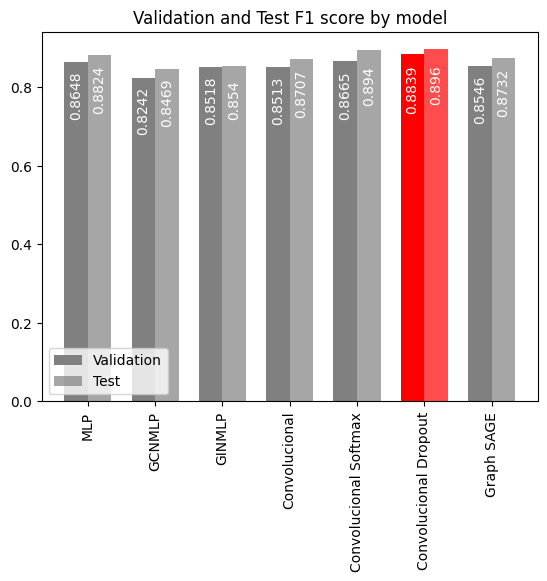

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Separate validation and test scores
val_scores = [scores[0] for scores in f1_by_model.values()]
test_scores = [scores[1] for scores in f1_by_model.values()]

# Define colors for the bars
colors_val = ['grey' if f1 != max(val_scores) else 'red' for f1 in val_scores]
colors_test = ['grey' if f1 != max(test_scores) else 'red' for f1 in test_scores]

# Create subplots
fig, ax = plt.subplots()

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(f1_by_model))

# Plot validation scores
bars_val = ax.bar(index, val_scores, bar_width, color=colors_val, label='Validation')

# Plot test scores
bars_test = ax.bar(index + bar_width, test_scores, bar_width, color=colors_test, label='Test', alpha=0.7)

# Add value labels inside each bar
for bar in bars_val + bars_test:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval * 0.9, round(yval, 4), ha='center', va='center', rotation='vertical', color='white')

# Rotate x-axis labels for better readability
plt.xticks(index + bar_width / 2, f1_by_model.keys(), rotation=90)

# Add title and legend
plt.title("Validation and Test F1 score by model")
plt.legend()

# Show plot
plt.show()


# Generar solución para el torneo

In [79]:
model = Convolucional_Droput(
    dataset.num_node_features,
    1024,
    dataset.num_classes
)

train_model(model, "Convolucional Dropout", data)

dataset.create_test_json(model, 'pred_labels.json', device='cuda')

Epoch 0: Loss 1.0956376791000366
Epoch 10: Loss 1.098576545715332
Epoch 20: Loss 1.0505106449127197
Epoch 30: Loss 0.7685238718986511
Epoch 40: Loss 0.6667629480361938
Epoch 50: Loss 0.45313823223114014
Epoch 60: Loss 0.35944318771362305
Epoch 70: Loss 0.32189396023750305
Epoch 80: Loss 0.27289557456970215
Epoch 90: Loss 0.25731411576271057


MODEL VALIDATION:

Validation F1 score: 0.8692957746478873


MODEL TEST:

Test F1 score: 0.8818458417849898
